# Model Training and Evaluation

> The "Model Training and Evaluation" notebook aims to train a machine learning model for the churn prediction task and evaluate its performance. 

The following steps are covered in this notebook:

1. **Feature Selection and Model Selection:** Select the desired features: "features_first_loop.csv" and "features_second_loop.csv". Select best performing model.

2. **Model Training and Evaluation:** The selected models are trained using the training dataset. Model hyperparameters are tuned using techniques like grid search or random search to optimize the model's performance. The trained model is evaluated using the testing dataset. Performance metrics such as accuracy, precision, recall, F1 score and ROC auc are computed to assess the model's predictive ability. Additionally, visualizations like confusion matrix or ROC curve may be used to analyze the model's performance.

3. **Model Deployment:** The deployment will be done using the Kedro framework for the model with the best performance.

In [1]:
from utils.utils import format_seaborn_plots
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Feature Selection and Model Selection

In [2]:
# Load data
df_features_first_loop = pd.read_csv('../data/04_feature/features_first_loop.csv')
df_features_second_loop = pd.read_csv('../data/04_feature/features_second_loop.csv')

# Create an empty DataFrame to store the model performance
model_control = pd.DataFrame(columns=['DataFrame', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'])

# Define a list of classifiers to train
classifiers = [
    RandomForestClassifier(),
    LogisticRegression(max_iter=10000),
    SVC(max_iter=10000),
    KNeighborsClassifier(),
    XGBClassifier() 
]

# Iterate over the dataframes
for df_name, df_features in [('features_first_loop', df_features_first_loop), ('features_second_loop', df_features_second_loop)]:
    # Split the data into training and testing sets
    X = df_features.drop('Exited', axis=1)
    y = df_features['Exited']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Apply standard scaling
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    # Train and evaluate each classifier
    for classifier in classifiers:
        # Train the classifier
        classifier.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = classifier.predict(X_test)

        # Evaluate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)

        # Append the model performance to the model_control DataFrame
        row = pd.DataFrame([[df_name, classifier.__class__.__name__, accuracy, precision, recall, f1, roc_auc]],
                           columns=['DataFrame', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'])
        model_control = pd.concat([model_control, row], ignore_index=True)

# Save the model_control DataFrame to a CSV file
model_control.to_csv('../docs/model_control.csv', index=False)

In [3]:
pd.DataFrame(model_control).head()

,DataFrame,Model,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,features_first_loop,RandomForestClassifier,0.8695,0.759843,0.491094,0.596600,0.726568
1,features_first_loop,LogisticRegression,0.8435,0.690476,0.368957,0.480929,0.664254
2,features_first_loop,SVC,0.8550,0.775401,0.368957,0.500000,0.671411
3,features_first_loop,KNeighborsClassifier,0.8325,0.613281,0.399491,0.483821,0.668943
4,features_first_loop,XGBClassifier,0.8540,0.681004,0.483461,0.565476,0.714039


**Conclusions:**
> From the results above, it can be seen a that the best performing models are **RandomForestClassifier** and **XGBClassifier**.

> Also theere was a slightly improvement in model's performance with the **features_second_loop.csv**

## 2. Model Training and Evaluation

More evalutions could be done in order to select the best model. But from now on it will be detailed the model evaluation and fine-Tuning process for **RandomForestClassifier** using **features_second_loop.csv**.

### 2.1 Comparing Undersampling and Oversampling 

To goal is to try to mitigate the data imbalance problem.

In [18]:
# Load data
df_features_second_loop = pd.read_csv('../data/04_feature/features_second_loop.csv')

# Create an empty DataFrame to store the model performance
model_control = pd.DataFrame(columns=['DataFrame', 'Sampling Technique', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'])

# Define a list of classifiers to train
classifiers = [RandomForestClassifier()]

# Define a list of sampling techniques
sampling_techniques = ['All Data', 'Undersampling', 'Oversampling']

# Iterate over the sampling techniques
for sampling in sampling_techniques:
    # Split the data into training and testing sets
    X = df_features_second_loop.drop('Exited', axis=1)
    y = df_features_second_loop['Exited']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Apply standard scaling
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    # Apply sampling techniques if necessary
    if sampling == 'Undersampling':
        sampler = RandomUnderSampler(random_state=42)
        X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)
    elif sampling == 'Oversampling':
        sampler = RandomOverSampler(random_state=42)
        X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)
    else:
        X_train_resampled = X_train
        y_train_resampled = y_train
    
    # Train and evaluate the RandomForest classifier
    for classifier in classifiers:
        # Train the classifier
        classifier.fit(X_train_resampled, y_train_resampled)

        # Make predictions on the test set
        y_pred = classifier.predict(X_test)

        # Evaluate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)

        # Append the model performance to the model_control DataFrame
        row = pd.DataFrame([[df_name, sampling, classifier.__class__.__name__, accuracy, precision, recall, f1, roc_auc]],
                           columns=['DataFrame', 'Sampling Technique', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'])
        model_control = pd.concat([model_control, row], ignore_index=True)

# Save the model_control DataFrame to a CSV file
model_control.to_csv('../docs/model_control_imbalance.csv', index=False)

In [19]:
pd.DataFrame(model_control).head()

,DataFrame,Sampling Technique,Model,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,features_second_loop,All Data,RandomForestClassifier,0.8710,0.764706,0.496183,0.601852,0.729423
1,features_second_loop,Undersampling,RandomForestClassifier,0.7825,0.467290,0.763359,0.579710,0.775270
2,features_second_loop,Oversampling,RandomForestClassifier,0.8585,0.683333,0.521628,0.591631,0.731256


Yeah, not much results from this analysis. Let's continue using the whole data.

### 2.2 RandomForest Classifier Fine-Tuning

In this section it will be explore using **RandomForestClassfier** and **features_second_loop.csv**.

In [22]:

# Load the data
df_features_second_loop = pd.read_csv('../data/04_feature/features_second_loop.csv')

# Split the data into features and target
X = df_features_second_loop.drop('Exited', axis=1)
y = df_features_second_loop['Exited']

# Perform standard scaling on the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the parameter grid for fine-tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Perform GridSearchCV for fine-tuning
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_scaled, y)

# Print the best parameters and the corresponding mean cross-validated score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

# Train the RandomForestClassifier with the best parameters
best_rf_classifier = RandomForestClassifier(**grid_search.best_params_, random_state=42)
best_rf_classifier.fit(X_scaled, y)

# Perform cross-validation on the best model
cross_val_scores = cross_val_score(best_rf_classifier, X_scaled, y, cv=5, scoring='accuracy')

# Print the cross-validated scores
print("Cross-validated Scores:")
for i, score in enumerate(cross_val_scores):
    print(f"Fold {i+1}: {score:.4f}")

Best Parameters:  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best Score:  0.8665
Cross-validated Scores:
Fold 1: 0.8640
Fold 2: 0.8770
Fold 3: 0.8605
Fold 4: 0.8685
Fold 5: 0.8625


### 2.3 Evaluation

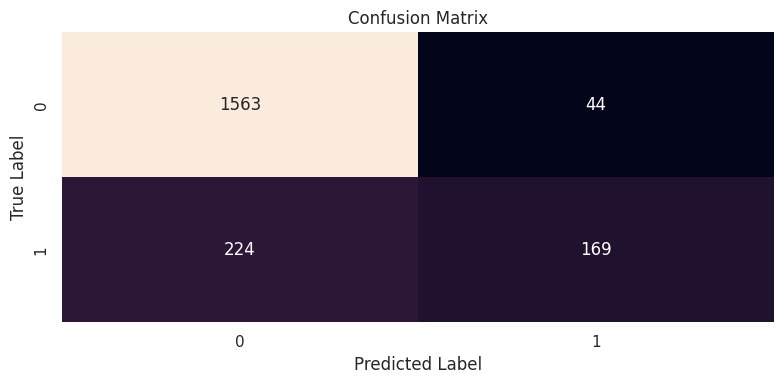

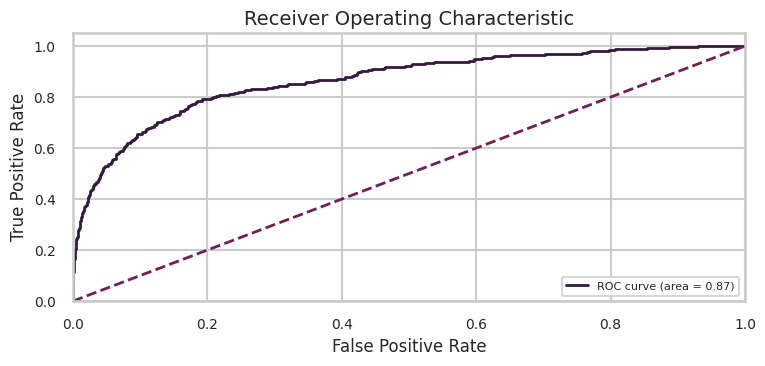

Accuracy: 0.866
Precision: 0.7934272300469484
Recall: 0.4300254452926209
F1-Score: 0.5577557755775578
ROC AUC: 0.8662847497668439


In [15]:
# Load the data
df_features_second_loop = pd.read_csv('../data/04_feature/features_second_loop.csv')

# Split the data into features and target
X = df_features_second_loop.drop('Exited', axis=1)
y = df_features_second_loop['Exited']

# Perform standard scaling on the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create and train the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)
y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Create confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn
format_seaborn_plots()
sns.set()
#plt.figure(figsize=(6,4))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap="rocket", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Generate ROC curve data
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
sns.set()
format_seaborn_plots()
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("ROC AUC:", roc_auc)


### Feature Importance

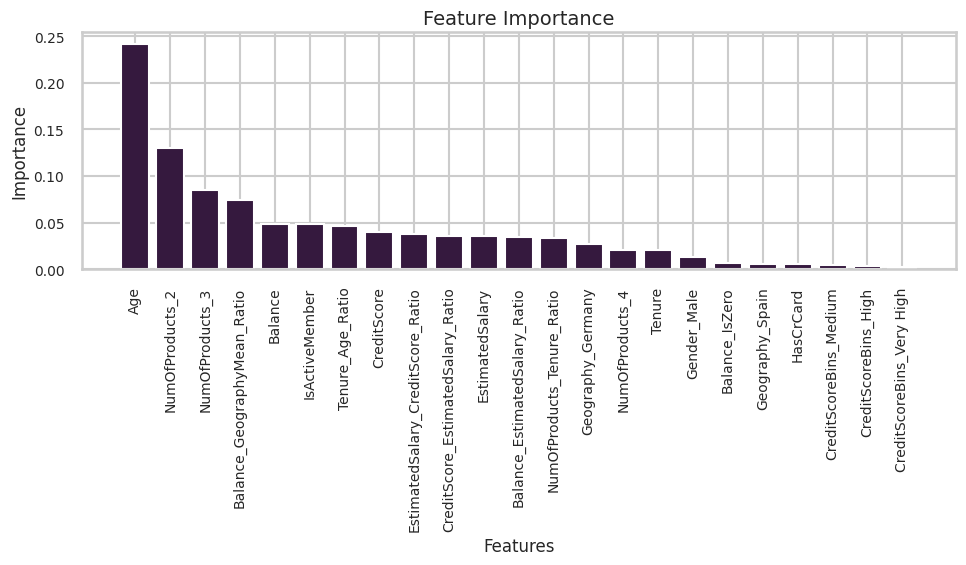

In [16]:

# Get feature importances from the trained model
importances = rf_classifier.feature_importances_
feature_names = X.columns

# Sort feature importances in descending order
indices = importances.argsort()[::-1]
sorted_feature_names = [feature_names[i] for i in indices]
sorted_importances = importances[indices]

# Plot feature importances
format_seaborn_plots()
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), sorted_importances, tick_label=sorted_feature_names)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

# Conclusion

> It could be done more iterations in feature engineering and model training and evaluation to enhance performance. For now, it will be used this final model to deploy into the kedro framework. Considering a production-ready model.

<p style="text-align: right;"><em>Author: Laiza Milena Scheid Parizotto</em></p>
<p style="text-align: right;"><em>Date: June 20th, 2023</em></p>